In [1]:
#dependencies
import pandas as pd
import numpy as np

In [2]:
#read in the country-medal file
filepath="countryMedalTally.csv"
data=pd.read_csv(filepath)

data.head()

,Region,MedalCount,Gold,Silver,Bronze
0,United States of America,5637,2638,1641,1358
1,Russia,3947,1599,1170,1178
2,Germany,3756,1301,1195,1260
3,United Kingdom,2068,678,739,651
4,France,1777,501,610,666


In [3]:
#get 4 corner bounds for each country
import googlemaps

from api_keys import gkey

gm = googlemaps.Client(key=gkey)
    
lat1 = [None]*len(data.Region)
lat2 = [None]*len(data.Region)
lng1 = [None]*len(data.Region)
lng2 = [None]*len(data.Region)

for i in range(len(data.Region)):
    try:
        geocode_result = gm.geocode(data.Region[i])[0]
        lat1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lat"]
        lat2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lat"]
        lng1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lng"]
        lng2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lng"]
    except:
        continue



In [4]:
#replace NaNs with 1s and -1s

for i in range(len(lat1)):
    if pd.isnull(lat1[i]):
        lat1[i]=0
        lat2[i]=0
        lng1[i]=0
        lng2[i]=0


In [5]:
data["lat1"]=lat1
data["lng1"]=lng1
data["lat2"]=lat2
data["lng2"]=lng2

#data.to_csv("medalTallyWithCountryBounds.csv",index=False)

data.head()

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2
0,United States of America,5637,2638,1641,1358,49.380000,-66.940000,25.820000,-124.390000
1,Russia,3947,1599,1170,1178,70.000000,179.000000,40.000000,27.000000
2,Germany,3756,1301,1195,1260,55.081500,15.041896,47.270111,5.866343
3,United Kingdom,2068,678,739,651,61.547111,9.584416,47.555449,-18.531959
4,France,1777,501,610,666,51.124200,9.662500,41.314330,-5.559100


In [6]:
data.lat1=data.lat1.astype(str)
data.lng1=data.lng1.astype(str)
data.lat2=data.lat2.astype(str)
data.lng2=data.lng2.astype(str)

In [7]:
data["bounds"]=data.lat1.str.cat(data.lng1,sep=",").str.cat(data.lat2,sep=",").str.cat(data.lng2,sep=",")

data.head()

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds
0,United States of America,5637,2638,1641,1358,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39"
1,Russia,3947,1599,1170,1178,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0"
2,Germany,3756,1301,1195,1260,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425"
3,United Kingdom,2068,678,739,651,61.5471111,9.5844157,47.5554486,-18.5319589,"61.5471111,9.5844157,47.5554486,-18.5319589"
4,France,1777,501,610,666,51.1241999,9.6624999,41.31433,-5.5591,"51.1241999,9.6624999,41.31433,-5.5591"


In [8]:
#dependencies

import requests
import json

from api_keys import aqikey

url="https://api.waqi.info/map/bounds/"

avgPollution=[None]*len(data["bounds"])


In [9]:
for i in range(len(data["bounds"])):
    response=requests.get(url,params={"token":aqikey,"latlng":data["bounds"][i]}).json()
    totalaqi=0
    if len(response["data"])>0:
        for j in range(len(response["data"])):
            try:
                totalaqi+=int(response["data"][j]["aqi"])
            except:
                continue
        avgPollution[i]=totalaqi/len(response["data"])
    else:
        continue
    

In [10]:
pollution_df=data
pollution_df["pollution"]=avgPollution
pollution_df=pollution_df.dropna()
pollution_df

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds,pollution
0,United States of America,5637,2638,1641,1358,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39",31.645390
1,Russia,3947,1599,1170,1178,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0",54.277419
2,Germany,3756,1301,1195,1260,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425",44.132075
3,United Kingdom,2068,678,739,651,61.5471111,9.5844157,47.5554486,-18.5319589,"61.5471111,9.5844157,47.5554486,-18.5319589",48.922857
4,France,1777,501,610,666,51.1241999,9.6624999,41.31433,-5.5591,"51.1241999,9.6624999,41.31433,-5.5591",44.220196
...,...,...,...,...,...,...,...,...,...,...,...
183,Malta,0,0,0,0,36.0853,14.5765999,35.79960000000001,14.1801001,"36.0853,14.5765999,35.79960000000001,14.1801001",36.750000
184,Mali,0,0,0,0,25.001084,4.267382599999999,10.147811,-12.2403447,"25.001084,4.267382599999999,10.147811,-12.2403447",194.000000
187,Palestine,0,0,0,0,32.5520999,35.5740521,31.219691,34.21010010000001,"32.5520999,35.5740521,31.219691,34.21010010000001",84.692308
188,Guinea,0,0,0,0,12.6748616,-7.637853,7.190909099999999,-15.282,"12.6748616,-7.637853,7.190909099999999,-15.282",128.500000


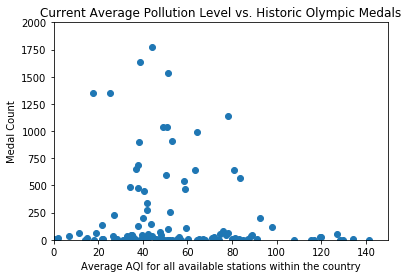

In [13]:
import matplotlib.pyplot as plt

plt.scatter(pollution_df.pollution,pollution_df.MedalCount)
plt.title("Current Average Pollution Level vs. Historic Olympic Medals")
plt.xlabel("Average AQI for all available stations within the country")
plt.ylabel("Medal Count")
plt.xlim(0,150)
plt.ylim(0,2000)

plt.show()

In [14]:
import scipy.stats as sts

coefficient=sts.pearsonr(pollution_df.pollution,pollution_df.MedalCount)[0]
pvalue=sts.pearsonr(pollution_df.pollution,pollution_df.MedalCount)[1]

print(f"The correlation is {round(coefficient,4)} and the p-value is {round(pvalue,4)}")

The correlation is -0.1051 and the p-value is 0.2532
